# Imports

In [331]:
import pandas as pd
import numpy as np
import re
import string
import json
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

GO TO SECTION 2.3 TO IMPORT DATA FROM PARQUET FILE

# EDA

## Movie Details

In [211]:
movie_details = pd.read_json('./data/IMDB_movie_details.json', lines=True)
display(movie_details.info())
movie_details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB


None

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...
...,...,...,...,...,...,...,...
1567,tt0289879,Evan Treborn grows up in a small town with his...,1h 53min,"[Sci-Fi, Thriller]",7.7,2004-01-23,"In the year 1998, Evan Treborn (Ashton Kutcher..."
1568,tt1723811,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ..."
1569,tt5013056,Evacuation of Allied soldiers from the British...,1h 46min,"[Action, Drama, History]",8.1,2017-07-21,The film alternates between three different pe...
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[Comedy, Drama]",5.3,1992-02-21,


Convert 'release_date' to a datetime object

In [212]:
movie_details['release_date'] = pd.to_datetime(movie_details.release_date)

Convert duration into a minute count (integer)

In [213]:
hour = re.compile('(\d+)h')
minute = re.compile('(\d+)min')

def duration_convert(df):
    # set intial duration to 0
    duration = 0
    # find number of hours and minutes
    hour_found = hour.findall(df.duration)
    minute_found = minute.findall(df.duration)
    # if hours, multiply value by 60 and add to duration
    if hour_found:
        duration += 60 * int(hour_found[0])
    # if minutes, add to duration
    if minute_found:
        duration += int(minute_found[0])
    # return total number of minutes
    return duration

movie_details['duration'] = movie_details.apply(duration_convert, axis=1)

Confirm that genre contains lists for possible future genre analysis

In [214]:
for i in list(range(len(movie_details))):
    count = 0
    if str(type(movie_details.iloc[i].genre)) != "<class 'list'>":
        count += 1
        print(type(movie_details.iloc[i].genre))
print(f"There are {count} entries for genre that are not a list")

There are 0 entries for genre that are not a list


_____________
Check on how many empty plot summary/synopsis there are

In [215]:
empty_summary = len(movie_details[movie_details.plot_summary == ''])
empty_synopsis = len(movie_details[movie_details.plot_synopsis == ''])
print(f"There are {empty_summary} entries with an empty summary.\nThere are {empty_synopsis} entries with an empty synopsis.")

There are 0 entries with an empty summary.
There are 233 entries with an empty synopsis.


In [216]:
first_summary_len = len(movie_details.iloc[0].plot_summary)
first_synopsis_len = len(movie_details.iloc[0].plot_synopsis)
print(f"The first entry summary length is: {first_summary_len}\nThe first entry synopsis length is: {first_synopsis_len}")

The first entry summary length is: 1034
The first entry synopsis length is: 8605


The first entry's summary and synopsis reveals that the former is shorter than the latter, which is the field containing some missing values. Checking the whole dataframe to see if that relationship is always the case.

In [217]:
count = 0

for i in list(range(len(movie_details))):
    summary_len = len(movie_details.iloc[i].plot_summary)
    synopsis_len = len(movie_details.iloc[i].plot_synopsis)
    if summary_len > synopsis_len:
        count += 1

difference = count - empty_synopsis
    
print(f"There are {count} entries where the summary length is greater than the synopsis length.")
print(f"There are {difference} of these entries that contain a synopsis.")

There are 256 entries where the summary length is greater than the synopsis length.
There are 23 of these entries that contain a synopsis.


With that many missing, we will use the film summary instead of synopsis.
____________
The quantity of unique values from movie_reviews' movie_id match the number of films we have in the movie details. Some of the movie_id values in the movie_details dataframe have a trailing '/' character which will affect matching when we merge the two dataframes.

In [273]:
def fix_movie_id(df):
    if df.movie_id[-1] == '/':
        return  df.movie_id[:-1]
    else:
        return df.movie_id

movie_details['movie_id'] = movie_details.apply(fix_movie_id, axis=1)

### Entity extraction of film summary

In [ ]:
def summary_entities(row):
    # get the film summary
    summary = row.plot_summary
    # generate new features for character and word count of the summary
    row['summary_char_count'] = len(summary)
    row['summary_word_count'] = len(summary.split(' '))
    # get the entities with spacy
    doc = nlp(summary)
    # initialize list of entities and their counts
    ent_list = []
    ent_count = []
    # append each entity to the list of entities
    for ent in doc.ents:
        ent_list.append(ent.text)
    # generate the set of unique entities
    ent_set = set(ent_list)
    # append a tuple to ent_count with each found entity and its count
    for ent in ent_set:
        ent_count.append((ent, ent_list.count(ent)))
    # set number of unique entities and initialize the total count to 0
    unique_ents = len(ent_count)
    unique_ent_count = 0
    # for each tuple, add the count from the entity frequency to the total count
    for x in ent_count:
        unique_ent_count += x[1]
    # get the average count for an entity
    if unique_ents != 0:
        avg_count = round(unique_ent_count / unique_ents, 2)
    else:
        avg_count = 0
    # generate new features for the total entity count, unique count, and avg frequency
    row['summary_entity_count'] = len(ent_list)
    row['summary_unique_entities'] = unique_ents
    row['summary_avg_entity_freq'] = avg_count
    # return the row
    return row

movie_details = movie_details.apply(summary_entities, axis=1)

### Tokenize film summary

In [ ]:
summary_stopwords = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)

def summary_tokenize(row):
    # get the film summary
    summary = row.plot_summary
    # tokenize
    summary_tokens = tokenizer.tokenize(summary)
    summary_tokens = [token.lower() for token in summary_tokens]
    summary_tokens = [token for token in summary_tokens if token not in summary_stopwords]
    # set new feature to token list
    row['summary_tokens'] = summary_tokens
    row['summary_token_count'] = len(summary_tokens)
    return row

movie_details = movie_details.apply(summary_tokenize, axis=1)

## Movie Reviews

In [ ]:
movie_reviews = pd.read_json('./data/IMDB_reviews.json', lines=True)
display(movie_reviews.info())
movie_reviews

In [ ]:
unique_movies_in_reviews = movie_reviews.movie_id.nunique()
print(f"There are {len(movie_details)} entries in movie_details and {unique_movies_in_reviews} unique movie_id's in movie_reviews")

Converting the review_date to datetime

In [ ]:
movie_reviews['review_date'] = pd.to_datetime(movie_reviews.review_date)

In [ ]:
movie_reviews.describe(datetime_is_numeric=True)

### Entity extraction of reviews

This processing takes just under 8 hours.

In [ ]:
nlp = spacy.load('en_core_web_sm')

def entity_info(row):
    # get the review summary
    review = row.review_text
    # generate new features for character and word count of the summary
    row['char_count'] = len(review)
    row['word_count'] = len(review.split(' '))
    # get the entities with spacy
    doc = nlp(review)
    # initialize list of entities and their counts
    ent_list = []
    ent_count = []
    # append each entity to the list of entities
    for ent in doc.ents:
        ent_list.append(ent.text)
    # generate the set of unique entities
    ent_set = set(ent_list)
    # append a tuple to ent_count with each found entity and its count
    for ent in ent_set:
        ent_count.append((ent, ent_list.count(ent)))
    # set number of unique entities and initialize the total count to 0
    unique_ents = len(ent_count)
    unique_ent_count = 0
    # for each tuple, add the count from the entity frequency to the total count
    for x in ent_count:
        unique_ent_count += x[1]
    # get the average count for an entity
    if unique_ents != 0:
        avg_count = round(unique_ent_count / unique_ents, 2)
    else:
        avg_count = 0
    # generate new features for the total entity count, unique count, and avg frequency
    row['entity_count'] = len(ent_list)
    row['unique_entities'] = unique_ents
    row['avg_entity_freq'] = avg_count
    # return the row
    return row

# movie_reviews = movie_reviews.apply(entity_info, axis=1)

### Tokenize reviews

In [ ]:
summary_stopwords = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)

def review_tokenize(row):
    # get the film review
    review = row.review_text
    # tokenize
    review_tokens = tokenizer.tokenize(review)
    review_tokens = [token.lower() for token in review_tokens]
    review_tokens = [token for token in review_tokens if token not in summary_stopwords]
    # set new feature to token list
    row['review_tokens'] = review_tokens
    row['review_token_count'] = len(review_tokens)
    return row

movie_reviews = movie_reviews.apply(review_tokenize, axis=1)

## Merging details and reviews

In [ ]:
# merged_df = pd.merge(movie_details, movie_reviews, on='movie_id', how="right")

# corrected_columns = ['movie_id', 'plot_summary', 'duration', 'genre', 'film_rating',
#                      'release_date', 'plot_synopsis', 'summary_char_count',
#                      'summary_word_count', 'summary_entity_count', 'summary_unique_entities',
#                      'summary_avg_entity_freq', 'summary_tokens', 'summary_token_count',
#                      'review_date', 'user_id', 'is_spoiler', 'review_text', 'reviewer_rating',
#                      'review_summary', 'review_char_count', 'review_word_count', 'review_entity_count',
#                      'review_unique_entities', 'review_avg_entity_freq', 'review_tokens',
#                      'review_token_count']

# merged_df.columns = corrected_columns

# merged_df.to_parquet('./data/full_dataframe.parquet')

This cell reads in the full dataframe from the saved parquet file. The file is large, 573,913 entries with 27 features, takes up about 1.9 GB of space. The load takes about a minute

In [2]:
merged_df = pd.read_parquet('./data/full_dataframe.parquet')

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573913 entries, 0 to 573912
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   movie_id                 573913 non-null  object        
 1   plot_summary             573913 non-null  object        
 2   duration                 573913 non-null  int64         
 3   genre                    573913 non-null  object        
 4   film_rating              573913 non-null  float64       
 5   release_date             573913 non-null  datetime64[ns]
 6   plot_synopsis            573913 non-null  object        
 7   summary_char_count       573913 non-null  int64         
 8   summary_word_count       573913 non-null  int64         
 9   summary_entity_count     573913 non-null  int64         
 10  summary_unique_entities  573913 non-null  int64         
 11  summary_avg_entity_freq  573913 non-null  float64       
 12  summary_tokens  

In [43]:
merged_df['is_spoiler'] = merged_df.is_spoiler.astype(int)

In [73]:
merged_df[merged_df.is_spoiler == 1].describe()

,duration,film_rating,summary_char_count,summary_word_count,summary_entity_count,summary_unique_entities,summary_avg_entity_freq,summary_token_count,is_spoiler,reviewer_rating,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_token_count
count,150924.000000,150924.000000,150924.000000,150924.000000,150924.000000,150924.000000,150924.000000,150924.000000,150924.0,150924.000000,150924.000000,150924.000000,150924.000000,150924.000000,150924.000000,150924.000000
mean,121.130384,7.280437,624.399572,117.458138,9.186948,7.519639,1.195440,59.630046,1.0,6.517665,1887.676731,334.893695,17.256136,13.035415,1.255999,173.760164
std,24.942642,0.948630,237.506254,41.978062,5.533847,4.162621,0.294963,22.895998,0.0,3.015940,1283.848098,223.272556,15.865584,10.606174,0.369803,118.606350
min,42.000000,2.400000,95.000000,15.000000,0.000000,0.000000,0.000000,8.000000,1.0,1.000000,50.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,105.000000,6.700000,426.750000,82.000000,5.000000,4.000000,1.000000,41.000000,1.0,4.000000,920.000000,166.000000,6.000000,6.000000,1.000000,85.000000
50%,119.000000,7.400000,593.000000,114.000000,8.000000,7.000000,1.120000,57.000000,1.0,7.000000,1459.000000,261.000000,12.000000,10.000000,1.170000,135.000000
75%,136.000000,8.000000,803.000000,147.000000,12.000000,10.000000,1.310000,77.000000,1.0,9.000000,2456.000000,435.000000,23.000000,17.000000,1.380000,226.000000
max,321.000000,9.500000,1077.000000,212.000000,31.000000,25.000000,3.330000,144.000000,1.0,10.000000,14302.000000,2565.000000,176.000000,129.000000,22.000000,1295.000000


In [74]:
merged_df[merged_df.is_spoiler == 0].describe()

,duration,film_rating,summary_char_count,summary_word_count,summary_entity_count,summary_unique_entities,summary_avg_entity_freq,summary_token_count,is_spoiler,reviewer_rating,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_token_count
count,422989.000000,422989.000000,422989.000000,422989.000000,422989.000000,422989.000000,422989.000000,422989.000000,422989.0,422989.000000,422989.000000,422989.000000,422989.000000,422989.000000,422989.000000,422989.000000
mean,120.942374,7.298383,627.095475,118.291052,9.237061,7.555986,1.196648,60.078194,0.0,7.110031,1308.154425,232.462291,11.540912,9.340723,1.148814,120.596046
std,25.483305,0.963094,238.361301,42.148712,5.541700,4.174949,0.296580,22.920865,0.0,2.918959,1021.050440,176.857803,12.086659,8.651105,0.357940,94.617510
min,42.000000,2.400000,95.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.0,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,104.000000,6.700000,431.000000,83.000000,5.000000,4.000000,1.000000,41.000000,0.0,5.000000,682.000000,124.000000,4.000000,4.000000,1.000000,63.000000
50%,118.000000,7.400000,593.000000,114.000000,8.000000,7.000000,1.120000,58.000000,0.0,8.000000,947.000000,171.000000,8.000000,7.000000,1.070000,87.000000
75%,135.000000,8.000000,800.000000,148.000000,12.000000,10.000000,1.310000,78.000000,0.0,10.000000,1575.000000,280.000000,14.000000,12.000000,1.250000,145.000000
max,321.000000,9.500000,1077.000000,212.000000,31.000000,25.000000,3.330000,144.000000,0.0,10.000000,14963.000000,2673.000000,213.000000,179.000000,45.000000,1333.000000


# Explore spoilers vs non-spoilers

Initial observations from the describe calls on reviews marked as spoiler versus ones that are not:
- The reviewer rating is about half a point lower on average for reviews marked as spoilers
- The review word count of a spoiler review is longer on average by about 44% (232 -> 335), but does have a more variation
- Rougly the same can be said about the entity counts (raw and unique)

It looks like there is nothing glaringly obvious about the difference between spoiler and non-spoiler reviews

## frequency

<AxesSubplot:ylabel='None'>

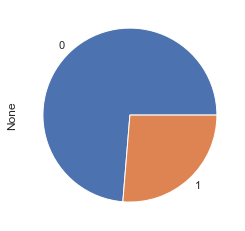

In [50]:
merged_df.groupby('is_spoiler').size().plot(kind='pie')

## by genre

Pull just the genre feature along with the target 'is_spoiler' so that each film is represented in each genre it's a part of.

In [81]:
genres = merged_df[['genre', 'is_spoiler']].explode('genre').copy()

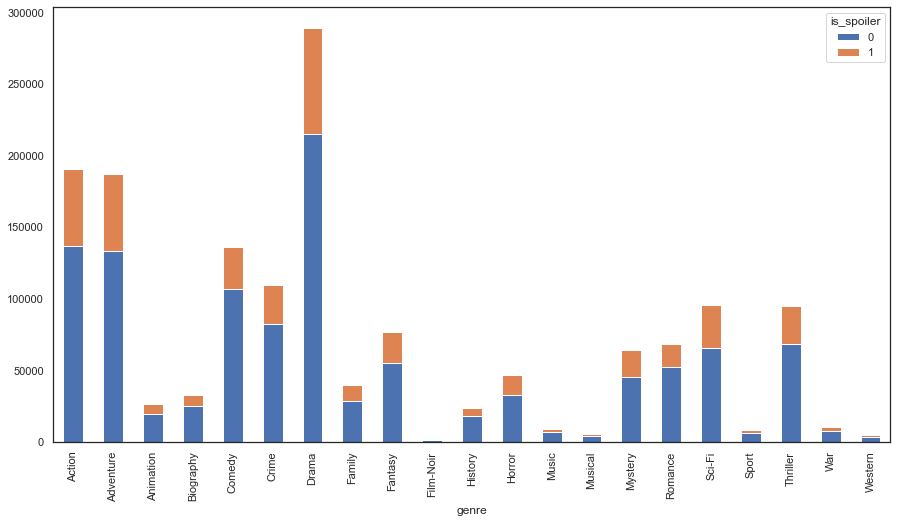

In [82]:
genres.groupby(['genre', 'is_spoiler']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,8));

In [83]:
genre_breakdown = genres.groupby(['genre', 'is_spoiler']).size().unstack()
# genre_breakdown['percent_true'] = genre_breakdown.apply(lambda x: x..True / (x.True + x.False))

In [85]:
genre_breakdown

is_spoiler,0,1
genre,,
Action,136820,53897
Adventure,133559,53734
Animation,19763,6834
Biography,25115,7992
Comedy,106658,29315
Crime,82659,27011
Drama,215137,74230
Family,28857,10702
Fantasy,55404,21694


## by user ID

In [57]:
user_ids = merged_df[['user_id', 'is_spoiler']].copy()
user_ids.user_id.value_counts()

ur2898520     1303
ur4248714     1021
ur0453068      806
ur60028700     770
ur20552756     755
              ... 
ur13992719       1
ur44287431       1
ur23173336       1
ur33891945       1
ur0156431        1
Name: user_id, Length: 263407, dtype: int64

In [348]:
user_ids.user_id.value_counts().values.sum() / len(user_ids.user_id.value_counts())

2.1788069413493187

There are 263,407 unique users represented in the data. We can see that the vast majority do not comment more than once. The average number of comments is 2.17. Lets look at our top 20 commenters.

In [349]:
user_id_split_df = user_ids.groupby(['user_id', 'is_spoiler']).size().unstack().sort_values(by=0, ascending=False)
user_id_split_df.
user_id_split_df[:20]

is_spoiler,0,1
user_id,,
ur2898520,1283.0,20.0
ur20552756,742.0,13.0
ur0453068,735.0,71.0
ur1234929,670.0,10.0
ur4888011,658.0,43.0
ur2488512,616.0,65.0
ur17646017,587.0,41.0
ur23055365,561.0,16.0
ur4445210,539.0,45.0


There are some null values where the user only has comments of one target class or the other. We will set them to zero

In [357]:
user_id_split_df.fillna(0.0, inplace=True)

In [365]:
testing = user_id_split_df.reset_index()
testing.columns = ['user_id', 'non_spoiler', 'spoiler']
testing

,user_id,non_spoiler,spoiler
0,ur2898520,1283.0,20.0
1,ur20552756,742.0,13.0
2,ur0453068,735.0,71.0
3,ur1234929,670.0,10.0
4,ur4888011,658.0,43.0
...,...,...,...
263402,ur9990913,0.0,1.0
263403,ur9992465,0.0,1.0
263404,ur9993627,0.0,1.0
263405,ur9995532,0.0,1.0


In [368]:
def total_and_percent(row):
    
    total = row.non_spoiler + row.spoiler
    row['total'] = total
    
    if row.non_spoiler == 0.0:
        row['percent_spoiled'] = 1.0
        
    else:
        row['percent_spoiled'] = row.spoiler / total
        
    return row

In [369]:
testing = testing.apply(total_and_percent, axis=1)

In [371]:
testing[testing.total > 5.0].sort_values(by='percent_spoiled', ascending=False)[:20]

,user_id,non_spoiler,spoiler,total,percent_spoiled
263335,ur9938570,0.0,112.0,112.0,1.0
225272,ur24052844,0.0,13.0,13.0,1.0
225820,ur24421425,0.0,7.0,7.0,1.0
225804,ur24409764,0.0,10.0,10.0,1.0
225796,ur24403695,0.0,14.0,14.0,1.0
225711,ur24340247,0.0,82.0,82.0,1.0
225652,ur24310671,0.0,6.0,6.0,1.0
225619,ur24292397,0.0,9.0,9.0,1.0
225386,ur24139670,0.0,6.0,6.0,1.0
225279,ur24062644,0.0,54.0,54.0,1.0


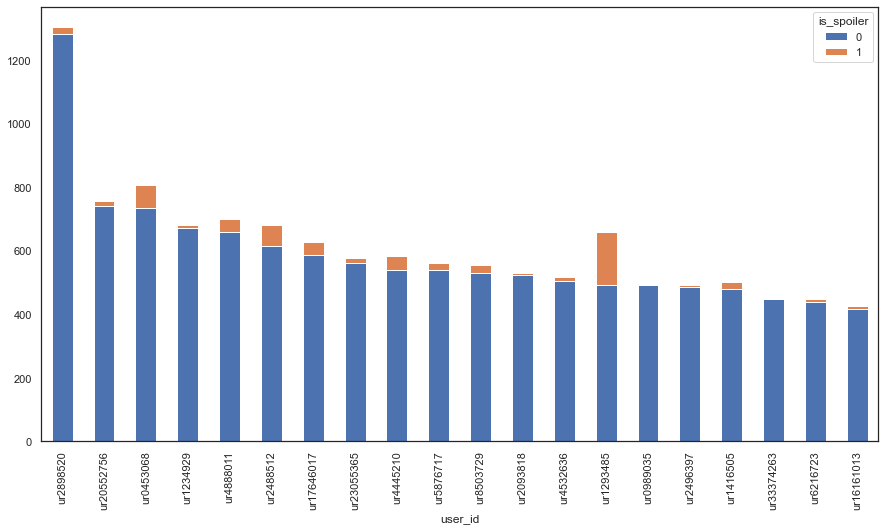

In [343]:
# top 20 reviewers by total count, separated into spoiler/non
user_ids.groupby(['user_id', 'is_spoiler']).size().unstack().sort_values(by=0, ascending=False)[:20].plot(kind='bar', stacked=True, figsize=(15,8));

# Helper functions

In [336]:
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)

## Testing section

Taking 1% of the large dataframe to run tests on, preserving the ratio of spoiler to non-spoiler reviews in the subset.

In [144]:
test_df = merged_df.groupby('is_spoiler').apply(lambda x: x.sample(frac=0.01))
test_df.reset_index(drop=True, inplace=True)

In [146]:
test_df.is_spoiler.value_counts(normalize=True)

0    0.737062
1    0.262938
Name: is_spoiler, dtype: float64

# Non-language feature modeling

Features which don't pertain to the summary or review text include:
- film duration
- genre
- rating
- release date
- review date
- is_spoiler (target)

In [175]:
non_lang_features = ['duration', 'genre', 'film_rating', 'release_date', 'review_date',
                     'is_spoiler']
non_language_df = merged_df[non_lang_features].copy()

Engineer a new feature: age of film at review

In [177]:
def film_age(df):
    age = df.review_date - df.release_date
    return age.days

non_language_df['days_since_release'] = non_language_df.apply(film_age, axis=1)
non_language_df.drop(['release_date', 'review_date'], axis=1, inplace=True)

Encode the genres. [Inspiration](https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list)

In [179]:
s = non_language_df['genre'].explode()
non_language_df = non_language_df[['duration', 'film_rating', 'is_spoiler',
                                   'days_since_release']].join(pd.crosstab(s.index, s))

## SGD Classifier

![image info](https://scikit-learn.org/stable/_static/ml_map.png)

We are going to try using a SGD classifer to see how well it performs

In [385]:
# set X and y
X = non_language_df.drop('is_spoiler', axis=1)
y = non_language_df['is_spoiler']

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scale the predictors
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Performing a grid search for optimized parameters. This runs in about 18 minutes, so it's commented out and the best parameters are listed below

In [195]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(clf, param_grid=params, cv=10, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)

Best params were:
- alpha: 0.0001
- loss: 'hinge'
- penalty: 'l2'

In [386]:
sgd_model = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
sgd_model.fit(X_train_s, y_train)

SGDClassifier()

In [387]:
y_pred = sgd_model.predict(X_test_s)

C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     84626
     spoiler       0.00      0.00      0.00     30157

    accuracy                           0.74    114783
   macro avg       0.37      0.50      0.42    114783
weighted avg       0.54      0.74      0.63    114783



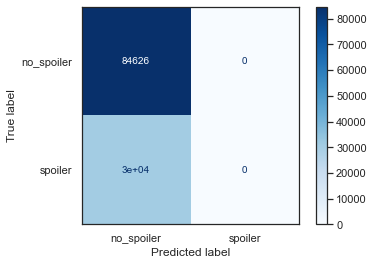

In [388]:
report(y_test, y_pred)

Modeling on the film review metadata we have does not look promising.

# Baseline Model

Our baseline model is going to say that any review that contains the word "spoiler" is, in-fact, a spoiler.

In [147]:
# make a baseline dataframe with just the target and the review_text
baseline_df = merged_df[['is_spoiler', 'review_text']].copy()

# create a new boolean value for reviews that contain the word 'spoiler'
baseline_df['contains_spoiler'] = baseline_df.review_text.str.contains('spoiler')
baseline_df['contains_spoiler'] = baseline_df.contains_spoiler.astype(int)

              precision    recall  f1-score   support

  no_spoiler       0.75      0.99      0.85    422989
     spoiler       0.60      0.06      0.10    150924

    accuracy                           0.74    573913
   macro avg       0.67      0.52      0.48    573913
weighted avg       0.71      0.74      0.65    573913



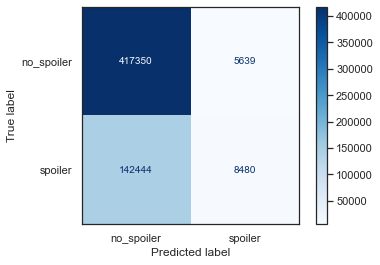

In [337]:
report(baseline_df.is_spoiler, baseline_df.contains_spoiler)

Baseline accuracy is about 74%, which sounds great, but the recall on spoilers is very low. The amount of false negatives is staggeringly high. Interestingly, there are lots of films whose review contains the word 'spoiler' but are not marked as such. That could something as simple as a user stating 'No spoilers follow', but it does seem curious to have that many film reviews that aren't spoilers.

# Bag of Words Model

In [219]:
summary_df = movie_details[['movie_id', 'plot_summary']].copy()
summary_df

,movie_id,plot_summary
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro..."
2,tt0243655,"The setting is Camp Firewood, the year 1981. I..."
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the..."
4,tt0126886,Tracy Flick is running unopposed for this year...
...,...,...
1567,tt0289879,Evan Treborn grows up in a small town with his...
1568,tt1723811,Brandon is a 30-something man living in New Yo...
1569,tt5013056,Evacuation of Allied soldiers from the British...
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B..."


In [221]:
review_df = merged_df[['movie_id', 'review_text', 'is_spoiler']].copy()
review_df

,movie_id,review_text,is_spoiler
0,tt0111161,"In its Oscar year, Shawshank Redemption (writt...",1
1,tt0111161,The Shawshank Redemption is without a doubt on...,1
2,tt0111161,I believe that this film is the best story eve...,1
3,tt0111161,"**Yes, there are SPOILERS here**This film has ...",1
4,tt0111161,At the heart of this extraordinary movie is a ...,1
...,...,...,...
573908,tt0139239,"Go is wise, fast and pure entertainment. Assem...",0
573909,tt0139239,"Well, what shall I say. this one´s fun at any ...",0
573910,tt0139239,"Go is the best movie I have ever seen, and I'v...",0
573911,tt0139239,Call this 1999 teenage version of Pulp Fiction...,0


## Bag of Words

Testing Dataframe to ensure things work before applying to all data. It's 1/1000th of the size, so any processing times multiply by 1000 and that will give the estimated time for application to the whole dataset

In [252]:
test_df = review_df.groupby('is_spoiler').apply(lambda x: x.sample(frac=0.001))
test_df.reset_index(drop=True, inplace=True)
test_df

,movie_id,review_text,is_spoiler
0,tt1013752,"The fourth film in the series. Placed, in time...",0
1,tt0327850,Welcome To The Jungle (AKA: The Rundown) is di...,0
2,tt1490017,Ca-shizzle ma dizzle. What a ride! There hasn'...,0
3,tt1288558,I love the new Evil Dead and I like it a lot m...,0
4,tt2911666,"The worst kind of film making. Truly awful, do...",0
...,...,...,...
569,tt0884328,The movie compares the mist with the path we'r...,1
570,tt2381249,"This, the fifth instalment in the Mission Impo...",1
571,tt0180093,Arsty-farsty shooting and gritty squalor canno...,1
572,tt1615065,This was an attempted comeback by Oliver Stone...,1


### Lemmatizing

In [265]:
sw = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
lemmatizer = nltk.stem.WordNetLemmatizer()

# helper function to correctly format the part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# helper function to clean and lemmatize the review
def lem_review(df):
    # get the review text
    doc = df.review_text
    # tokenize the review, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the review
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned review
    return doc_cleaned

In [283]:
review_df['review_text_lemmed'] = review_df.apply(lem_review, axis=1)

In [284]:
review_df

,movie_id,review_text,is_spoiler,review_text_lemmed
0,tt0111161,"In its Oscar year, Shawshank Redemption (writt...",1,oscar year shawshank redemption write direct f...
1,tt0111161,The Shawshank Redemption is without a doubt on...,1,shawshank redemption without doubt one brillia...
2,tt0111161,I believe that this film is the best story eve...,1,believe film best story ever tell film i'm tel...
3,tt0111161,"**Yes, there are SPOILERS here**This film has ...",1,yes spoiler film emotional impact find hard wr...
4,tt0111161,At the heart of this extraordinary movie is a ...,1,heart extraordinary movie brilliant indelible ...
...,...,...,...,...
573908,tt0139239,"Go is wise, fast and pure entertainment. Assem...",0,go wise fast pure entertainment assemble excep...
573909,tt0139239,"Well, what shall I say. this one´s fun at any ...",0,well shall say one fun rate three plotlines or...
573910,tt0139239,"Go is the best movie I have ever seen, and I'v...",0,go best movie ever see i've see lot movie read...
573911,tt0139239,Call this 1999 teenage version of Pulp Fiction...,0,call teenage version pulp fiction whatever wan...


In [282]:
# first_document = test_df.iloc[0].review_text

# # tokenize the document, lowercase all words and remove stopwords
# first_doc = tokenizer.tokenize(first_document)
# first_doc = [token.lower() for token in first_doc]
# first_doc = [token for token in first_doc if token not in sw]

# # tag the document with the part of speech
# first_doc_tagged = pos_tag(first_doc)
# # change the tagging to the correct format using helper function above
# first_doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in first_doc_tagged]
# # lemmatize the tagged document
# first_doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in first_doc_tagged]
# # combine the list of lemmas into a string
# first_doc_clean = ' '.join(first_doc_lemmed)
# first_doc_clean

# test_df['review_text_lemmed'] = test_df.apply(lem_review, axis=1)

## first model - multinomial naive bayes

In [324]:
# set X to the review text lemmed, y to target
X = review_df.review_text_lemmed
y = review_df.is_spoiler

# We want 20% of our data for test and 20% for validation, generate our holdout number
holdout = round(len(X) * 0.2)

In [317]:
# do first train/test split for train/val set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42, test_size=holdout)

# perform 2nd train/test split (on train/val) for train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42, test_size=holdout)

# confirm shapes
print(f"X_train / y_train shapes: {X_train.shape}, {y_train.shape}")
print(f"X_val / y_val shapes: {X_val.shape}, {y_val.shape}")
print(f"X_test / y_test shapes: {X_test.shape}, {y_test.shape}")

In [328]:
# set tfidf vectorizer
tf_vec = TfidfVectorizer()

# fit/transfrom X_train, convert to dataframe and set columns/index
X_train_vec = tf_vec.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tf_vec.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

# transform X_val, convert to dataframe and set columns/index
X_val_vec = tf_vec.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tf_vec.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)


"""
This section can be uncommented to use count vectorizer instead
"""
# set count vectorizer
# c_vec = CountVectorizer()

# fit/transfrom X_train, convert to dataframe and set columns/index
# X_train_vec = c_vec.fit_transform(X_train)
# X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
# X_train_vec.columns = sorted(tf_vec.vocabulary_)
# X_train_vec.set_index(y_train.index, inplace=True)

# transform X_val, convert to dataframe and set columns/index
# X_val_vec = c_vec.transform(X_val)
# X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
# X_val_vec.columns = sorted(c_vec.vocabulary_)
# X_val_vec.set_index(y_val.index, inplace=True)

In [332]:
# instantiate multinomial naive bayes model
mnb = MultinomialNB()

# fit to X_train_vec/y_train
mnb.fit(X_train_vec, y_train)

# generate y_pred
y_pred = mnb.predict(X_val_vec)

MultinomialNB()

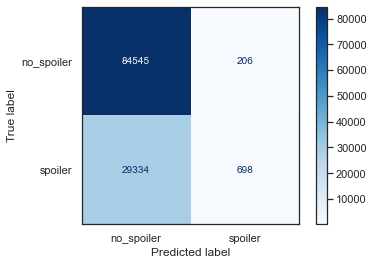

In [334]:
confusion_matrix_plot(y_val, y_pred, class_names=['no_spoiler', 'spoiler'])

In [335]:
print(classification_report(y_val, y_pred, target_names=['no_spoiler', 'spoiler']))

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     84751
     spoiler       0.77      0.02      0.05     30032

    accuracy                           0.74    114783
   macro avg       0.76      0.51      0.45    114783
weighted avg       0.75      0.74      0.64    114783



## second model - MNB restrict frequency

In [372]:
# set X to the review text lemmed, y to target
X = review_df.review_text_lemmed
y = review_df.is_spoiler

# We want 20% of our data for test and 20% for validation, generate our holdout number
holdout = round(len(X) * 0.2)

In [373]:
# do first train/test split for train/val set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42, test_size=holdout)

# perform 2nd train/test split (on train/val) for train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42, test_size=holdout)

# confirm shapes
print(f"X_train / y_train shapes: {X_train.shape}, {y_train.shape}")
print(f"X_val / y_val shapes: {X_val.shape}, {y_val.shape}")
print(f"X_test / y_test shapes: {X_test.shape}, {y_test.shape}")

X_train / y_train shapes: (344347,), (344347,)
X_val / y_val shapes: (114783,), (114783,)
X_test / y_test shapes: (114783,), (114783,)


In [374]:
# set tfidf vectorizer
tf_vec = TfidfVectorizer(min_df=0.05, max_df=0.95)

# fit/transfrom X_train, convert to dataframe and set columns/index
X_train_vec = tf_vec.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tf_vec.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

# transform X_val, convert to dataframe and set columns/index
X_val_vec = tf_vec.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tf_vec.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [375]:
# instantiate multinomial naive bayes model
mnb_v2 = MultinomialNB()

# fit to X_train_vec/y_train
mnb_v2.fit(X_train_vec, y_train)

# generate y_pred
y_pred = mnb_v2.predict(X_val_vec)

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     84742
     spoiler       0.33      0.00      0.00     30041

    accuracy                           0.74    114783
   macro avg       0.54      0.50      0.43    114783
weighted avg       0.63      0.74      0.63    114783



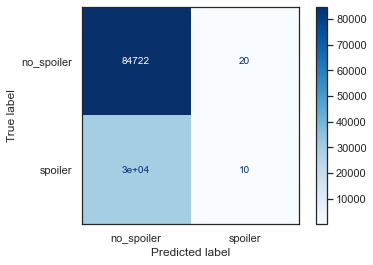

In [377]:
report(y_test, y_pred)

# testing

In [293]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = vec.fit_transform(test_df.review_text)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
df_cv.head()

,aaron,aback,abandoned,abandons,abba,abc,abcs,abducted,aberrant,abhorrence,...,zones,zoo,zooey,zoom,zooms,zootopia,zorro,zuckerberg,zurer,zwick
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = tf_vec.fit_transform(test_df.review_text)

df = pd.DataFrame(X.toarray(), columns = tf_vec.get_feature_names_out())
df.head()

,aaron,aback,abandoned,abandons,abba,abc,abcs,abducted,aberrant,abhorrence,...,zones,zoo,zooey,zoom,zooms,zootopia,zorro,zuckerberg,zurer,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [289]:
test_df.iloc[0].review_text

'The fourth film in the series. Placed, in time, somewhere between the first and the third. I am not completely sure whether this film plays before the second film, or after the second film - both scenarios would work out. Anyway, being the fourth film in the series there is little left to be explained and so the action starts rolling right from the very first seconds of the film and it doesn\'t run flat until a long while later. The story line is more or less the same as the first film and the roles being played out are much the same too.In fact, that is where this film fails to work out all that well - it is too much of a copy of the original one and although its subtitle is "original parts" that really does not make it worth the cinema time - the first film is not so old that there is a whole generation of people between that one and this one. It is not a bad film and for the fans of the series this is a worthy watch but I would have hoped they had done some more work on the story l

In [290]:
df.iloc[0].sort_values(ascending=False)[:10]

film         0.401541
fourth       0.248957
series       0.246509
first        0.208117
work         0.205230
line         0.167590
second       0.157543
original     0.154912
scenarios    0.153312
would        0.139922
Name: 0, dtype: float64

In [294]:
df_cv.iloc[0].sort_values(ascending=False)[:10]

film      11
first      4
series     3
work       3
one        3
would      3
fourth     2
story      2
much       2
second     2
Name: 0, dtype: int64